<a href="https://colab.research.google.com/github/jpsiegel/Projects/blob/master/Tarea1_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tarea 1 Jan P. Siegel - Deep Learning


In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

In [3]:
GPUs = GPU.getGPUs()
gpu = GPUs[0]  # Only one GPU on Colab and not guaranteed

def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " | Used: " + humanize.naturalsize(process.memory_info().rss))
  print("VRAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

RAM Free: 12.7 GB  | Used: 287.6 MB
VRAM Free: 15106MB | Used: 3MB | Util   0% Total 15109MB


##Parte 1



###Actividad 1

Una capa convolucional con kernel de 1x1 se usa para aumentar o disminuir las dimensiones del tensor entrante. Por ejemplo, si tenemos una imagen con RGB (3 canales), y los colores no aportan informacion para nuestro problema (nos basta con 1 canal), entonces podemos aplicar un layer convolucional con 1 filtro de 1x1, stride 1 para lograr lo requerido. Asimismo, aplicando muchos filtros 1x1 podemos lograr el aumento de dimensionalidad.

###Actividad 2

En teoría, esperamos al menos una precision igual o mayor para una red de alta profundidad (R1) que una de mediana profundidad (R2), ya que R1 podría poner algunas de sus capas en funcion identidad (fId) (dejar el input inalterado) y las demás capas tenerlas igual que R2. Pero es difícil para R1 entrenar capas con fId mediante múltiples capas no lineares. Es por esto que reformular el entrenamiento a aprender valores residuales ayuda, puesto que le pasamos a las capas posteriores de la red (mediante shortcuts feed forward) el input de las capas anteriores, por lo que si necesita generar dicha fId, solo debe dejar sus neuronas en 0. De esta forma podemos aprovechar el potencial de redes más profundas sin explotar su complejidad de entrenamiento.

###Actividad 7

In [ ]:
import torch
import torchvision.models as models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alexnet = models.alexnet(pretrained=True).to(device).eval()
vgg19 = models.vgg19(pretrained=True).to(device).eval()


In [31]:
print(vgg19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
!pip install torch-lucent
!pip install -U matplotlib --verbose

from lucent.optvis import render, param, transform, objectives

100%|██████████| 512/512 [00:09<00:00, 55.57it/s]



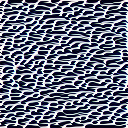

In [58]:
# Inicial (output de 3ra capa conv)
_ = render.render_vis(vgg19, "features_6:1", show_inline=True) # "capa:canal", show_inline=True printea imagen

100%|██████████| 512/512 [00:11<00:00, 41.79it/s]

Interrupted optimization at step 512.



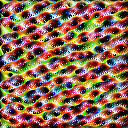

In [69]:
# Visualizacion de capa intermedia (output de 19na capa conv)
_ = render.render_vis(vgg19, "features_20:100", transforms=[transform.jitter(8)], show_inline=True) 


100%|█████████▉| 510/512 [00:16<00:00, 30.33it/s]

Interrupted optimization at step 512.



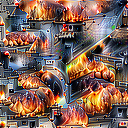

In [75]:
# Visualizacion de capa final (output de 34ava capa conv)
_ = render.render_vis(vgg19, "features_35:511", show_inline=True) 

En esta actividad estamos visualizando capas a distintas profundidades de una red entrenada para reconocimiento de imagenes de alta resolucion: VGG, la cual se caracteriza por ser bastante profunda, contando con 16 capas convolucionales.

La primera visualización desplegada corresponde a una imagen que activa fuertemente el primer canal del output de la 5ta capa convolucional, lo que nos permite representar de alguna forma el patron que pretende capturar el filtro seleccionado. Podemos ver que un patron relativamente simple de lineas o segmentos semi ordenados en blanco y negro activa fuertemente este canal, lo que recuerda lluvia, mar, madera o arena, pero podría ser aplicable a casi cualqier cosa.

En la segunda visualización podemos apreciar ya un patron bastante más elaborado, correspondiente al canal 100 de la 19na capa convolucional. La imagen podría sugerirnos que este filtro se especializó en reconocer círculos alineados, lo que podría ser muy útil para encontrar pares de ojos, por ejemplo.

Llegando a la tercera visualización, vemos un patron que sin duda es altamente complejo e intrincado. Acá ya estamos en el último canal de la última capa de la red VGG. Podemos observar un cuadro bastante abstracto, que probablemente resultó de la composición de muchas capas anteriores, en donde se podría intuir la aparición de contornos arquitectónicos, entremezclados con lo que pareciera ser llamas o fuego. Esto podría resultar de utilidad para descubrir un incendio en un edificio, por ejemplo.

#Referencias

1. *K. He, X. Zhang, S. Ren, and J. Sun. Deep residual learning for image recognition. In CVPR.*
1. *Lucent Repo Tutorial* https://github.com/greentfrapp/lucent